In [1]:
!pip install wget
!pip install chart_studio

In [2]:
from collections import Counter
from nltk.corpus import stopwords
import nltk
import collections
from textblob import TextBlob
from wordcloud import WordCloud
import wget
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)
import plotly.graph_objs as go
import chart_studio.plotly as py
import cufflinks
pd.options.display.max_columns = 30
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

In [3]:
pd.set_option('precision', 2)

### Dowloading dataset

In [4]:
wget.download("https://ml-coding-test.s3.eu-west-1.amazonaws.com/webis_train.csv", './webis_train.csv')
wget.download("https://ml-coding-test.s3.eu-west-1.amazonaws.com/webis_test.csv", './webis_test.csv')

'./webis_train (1).csv'

'./webis_test (1).csv'

### Reading dataset

In [5]:
df = pd.read_csv("webis_train.csv", delimiter=',', header=0)
# Removing nan values to simplify training process / I will only use postText to classify each instance
df_train = df[["postText", "truthClass"]].dropna()


df = pd.read_csv("webis_test.csv", delimiter=',', header=0)
# Removing nan values to simplify training process / I will only use postText to classify each instance
df_test = df[["postText", "truthClass"]].dropna()

### Analyzing length of instances per subset and class

In [6]:
n_words = lambda x: len(x.split(" "))

#### Number of words per instance in training set



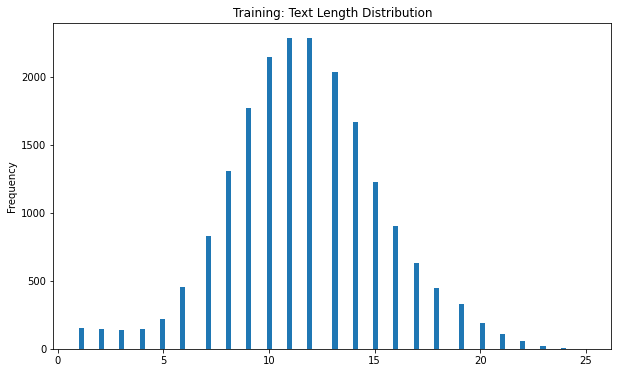

In [7]:
df_train['postText_len'] = df_train['postText'].astype(str).apply(n_words)
df_train['postText_len'].plot(
    kind='hist',
    bins=100,
    title='Training: Text Length Distribution')

#### Number of words per instance in Test set

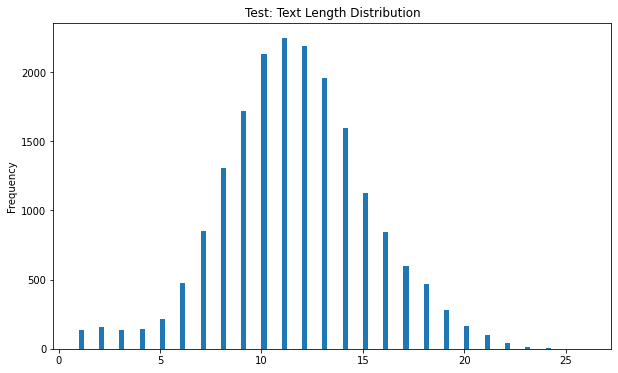

In [8]:
df_test['postText_len'] = df_test['postText'].astype(str).apply(n_words)
df_test['postText_len'].plot(
    kind='hist',
    bins=100,
    title='Test: Text Length Distribution')

#### Number of words per instance in training set (Positive Class)



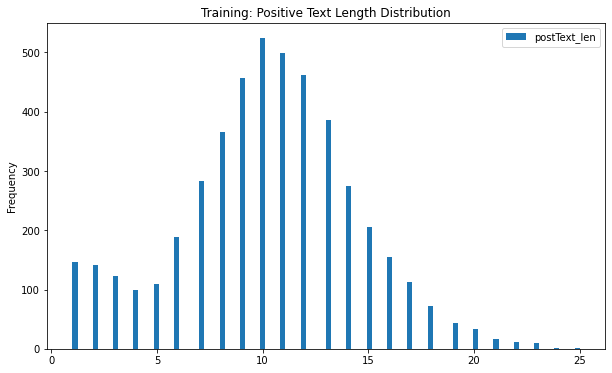

In [9]:
df_train.loc[df_train.truthClass == "clickbait", ['postText_len']].plot(
    kind='hist',
    bins=100,
    title='Training: Positive Text Length Distribution')

#### Number of words per instance in training set (Negative Class)


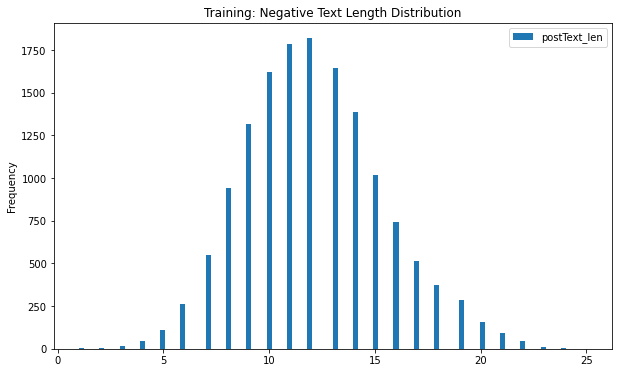

In [10]:
df_train.loc[df_train.truthClass != "clickbait", ['postText_len']].plot(
    kind='hist',
    bins=100,
    title='Training: Negative Text Length Distribution')

Acerca de la lonigitud de los mensajes. Utilizando un split basado unicamente en espacio, se puede observar que los datos de ambas clases (positiva y negativa), siguen patrones de longitud similares; concentrandose la maximas frecuencias sobretodo en mensajes de alrededor de 10 tokens. En un principio es de esperar que no haya ningún problema con limitaciones de tamaño impuestas por BERT y similares.


### Analyzing distribution of classes



In [11]:
print("Training data: Number of negative instances:", len(df_train.loc[df_train.truthClass != "clickbait"]))
print("Training data: Number of positive instances:", len(df_train.loc[df_train.truthClass == "clickbait"]))

Training data: Number of negative instances: 14768
Training data: Number of positive instances: 4716


In [12]:
print("Test data: Number of negative instances:", len(df_test.loc[df_test.truthClass != "clickbait"]))
print("Test data: Number of positive instances:", len(df_test.loc[df_test.truthClass == "clickbait"]))

Test data: Number of negative instances: 14455
Test data: Number of positive instances: 4458


Este problema se presenta como una tarea de clasificación con distribuciones entre clases desbalanceadas. Enfoques como medidas de evaluación Macro, permitiran conocer el performance de los sistemas desarrollados prestando detalle a la clase minoritaria i.e. la relevante en este caso.

### Analyzing most frequent words per class

In [13]:
nltk.download('stopwords')

filter_out = lambda x: x not in stopwords.words("english")

most_frequent_words_neg = Counter([x for x in " ".join(df_train.loc[df_train.truthClass != "clickbait", "postText"]).lower().split() if filter_out(x)]).most_common(100)
most_frequent_words_pos = Counter([x for x in " ".join(df_train.loc[df_train.truthClass == "clickbait", "postText"]).lower().split() if filter_out(x)]).most_common(100)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
# Positive values: Terms are more related to non-clickbait class
# Negative values: Terms are more related to clickbait class
most_frequent_words = {x:y
    for x,y in most_frequent_words_neg
}
for x, y in most_frequent_words_pos:
  most_frequent_words[x] = most_frequent_words.get(x, 0)-y

In [15]:
most_frequent_words = {k: v for k, v in sorted(most_frequent_words.items(), key=lambda item: item[1])}

In [16]:
for x in most_frequent_words:
  print("The term:", x, "appears ", most_frequent_words[x], "times more in the non-clickbait set than in the postive set.")

The term: things appears  -125 times more in the non-clickbait set than in the postive set.
The term: 10 appears  -90 times more in the non-clickbait set than in the postive set.
The term: 5 appears  -72 times more in the non-clickbait set than in the postive set.
The term: really appears  -58 times more in the non-clickbait set than in the postive set.
The term: stories appears  -55 times more in the non-clickbait set than in the postive set.
The term: 7 appears  -54 times more in the non-clickbait set than in the postive set.
The term: here’s appears  -51 times more in the non-clickbait set than in the postive set.
The term: see appears  -50 times more in the non-clickbait set than in the postive set.
The term: ways appears  -50 times more in the non-clickbait set than in the postive set.
The term: here's appears  -47 times more in the non-clickbait set than in the postive set.
The term: much appears  -47 times more in the non-clickbait set than in the postive set.
The term: good app

La frecuencia de los terminos es un factor que se puede ver comprometido por el número de documentos de cada clase. En sentido destaca la frecuencia > 0 del termino Trump (trump+Trump). Una forma de segmentar estos valores es estudiando el sentimiento en el cual se contextualizan estas menciones. Por otro lado, indicando frecuencias < 0 una presencia sobretodo en la clase "clickbait", destacan propias de anuncios: "sex", "love", "biggest".

In [17]:
def ngrams(text, n=2):
     return zip(*[text[i:] for i in range(n)])
ngram_counts_neg = collections.Counter(ngrams(" ".join(df_train.loc[df_train.truthClass != "clickbait", "postText"]).lower().split(), 3)).most_common(100)
ngram_counts_post = collections.Counter(ngrams(" ".join(df_train.loc[df_train.truthClass == "clickbait", "postText"]).lower().split(), 3)).most_common(100)

In [18]:
most_frequent_ngrams = {" ".join(terms):y
    for terms, y in ngram_counts_neg
}
for x, y in ngram_counts_post:
  most_frequent_ngrams[" ".join(x)] = most_frequent_ngrams.get(" ".join(x), 0)-y

In [19]:
most_frequent_ngrams = {k: v for k, v in sorted(most_frequent_ngrams.items(), key=lambda item: item[1])}

In [20]:
for x in most_frequent_ngrams:
  print("This expression:", x, "appears ", most_frequent_ngrams[x], "times more in the non-clickbait set than in the postive set")

This expression: you need to appears  -36 times more in the non-clickbait set than in the postive set
This expression: from the day appears  -28 times more in the non-clickbait set than in the postive set
This expression: stories from the appears  -25 times more in the non-clickbait set than in the postive set
This expression: these are the appears  -24 times more in the non-clickbait set than in the postive set
This expression: need to know appears  -20 times more in the non-clickbait set than in the postive set
This expression: of the most appears  -19 times more in the non-clickbait set than in the postive set
This expression: briefing: here's what appears  -18 times more in the non-clickbait set than in the postive set
This expression: #entertainment stories from appears  -17 times more in the non-clickbait set than in the postive set
This expression: will make you appears  -17 times more in the non-clickbait set than in the postive set
This expression: #news stories from appears  

Extendiendo el analisis de unigramas a trigramas, podemos observar que la clase "clickbait" concentra mensajes como "you need to", "will make you"... que asemejan mas a lo que cabría esperar de esta clase. Sobretodo por que son mensajes explicitamente dirigidos hacia el lector.

### Sentiment Analysis

In [21]:
polarity_neg = []
subjectivity_neg = []
for instance in df_train.loc[df_train.truthClass != "clickbait", "postText"]:
  s = TextBlob(instance).sentiment
  polarity_neg.append(s.polarity)
  subjectivity_neg.append(s.subjectivity)
polarity_pos = []
subjectivity_pos = []
for instance in df_train.loc[df_train.truthClass == "clickbait", "postText"]:
  s = TextBlob(instance).sentiment
  polarity_pos.append(s.polarity)
  subjectivity_pos.append(s.subjectivity)

In [22]:
print("Polarity analysis")
print("===============================")
print("Average Polarity scores NEGATIVE CLASS:", sum(polarity_neg)/len(polarity_neg))
print("Avergage Polarity scores POSITIVE CLASS:", sum(polarity_pos)/len(polarity_pos))
print("Min Polarity scores NEGATIVE CLASS:", min(polarity_neg))
print("Min Polarity scores POSITIVE CLASS:", min(polarity_pos))
print("Max Polarity scores NEGATIVE CLASS:", max(polarity_neg))
print("Max Polarity scores POSITIVE CLASS:", max(polarity_pos))
print("\n\n")
print("Subjectivity analysis")
print("===============================")
print("Average Subjectivity scores NEGATIVE CLASS:", sum(subjectivity_neg)/len(subjectivity_neg))
print("Avergage Subjectivity scores POSITIVE CLASS:", sum(subjectivity_pos)/len(subjectivity_pos))
print("Min Subjectivity scores NEGATIVE CLASS:", min(subjectivity_neg))
print("Min Subjectivity scores POSITIVE CLASS:", min(subjectivity_pos))
print("Max Subjectivity scores NEGATIVE CLASS:", max(subjectivity_neg))
print("Max Subjectivity scores POSITIVE CLASS:", max(subjectivity_pos))

Polarity analysis
Average Polarity scores NEGATIVE CLASS: 0.04885960892821125
Avergage Polarity scores POSITIVE CLASS: 0.09154955352984637
Min Polarity scores NEGATIVE CLASS: -1.0
Min Polarity scores POSITIVE CLASS: -1.0
Max Polarity scores NEGATIVE CLASS: 1.0
Max Polarity scores POSITIVE CLASS: 1.0



Subjectivity analysis
Average Subjectivity scores NEGATIVE CLASS: 0.2648735186161555
Avergage Subjectivity scores POSITIVE CLASS: 0.3246519286638034
Min Subjectivity scores NEGATIVE CLASS: 0.0
Min Subjectivity scores POSITIVE CLASS: 0.0
Max Subjectivity scores NEGATIVE CLASS: 1.0
Max Subjectivity scores POSITIVE CLASS: 1.0


Ambas clases tienden a usar estructuras neutras en cuanto a un analisis de sentimiento (basico). Respecto a Subjectivity y siendo esta una medida que representa Personal Opinions Vs Factual Information, destaca aunque no en gran medida la presencia de opiniones personales en el conjunto de clickbaits.

### Visualizing frecuency of words (Word Cloud)

In [23]:
def get_wordcloud(data):
  long_string = ','.join(list(data.values))
  wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', collocations = False)
  wordcloud.generate(long_string)
  return wordcloud

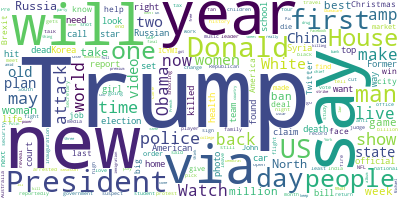

In [24]:
get_wordcloud(df_train.loc[df_train.truthClass != "clickbait", "postText"]).to_image()

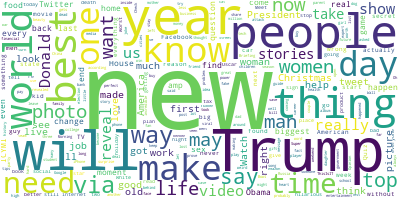

In [25]:
get_wordcloud(df_train.loc[df_train.truthClass == "clickbait", "postText"]).to_image()

Esta representación viene a mostrar graficamente lo analizado en las anteriores celdas aunque de forma aislada (i.e. el tamaño de cada termino no guarda relación entre figuras). Como se puede observar, la tendencia de expresiones como "best", "year", "thing", y "world" difere en gran medida entre ambos conjuntos.